In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['share-img', 'wedding-images']


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import shutil

import tensorflow as tf
#from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


print(os.listdir("../input/wedding-images/"))
print(os.listdir("../input/share-img/wedding_images"))

Using TensorFlow backend.


['model_multi_label.h5', 'Img_Style_Tag.csv']
['wedding_images']


In [3]:
base_tile_dir = '../input/share-img/wedding_images/wedding_images'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.jpeg'))})

#print (df.head())

df['id'] = df.path.map(lambda x: x.split('/')[5])

labels = pd.read_csv("../input/wedding-images/Img_Style_Tag.csv")
labels = labels.rename(columns={'img_file':'id'})
labels = labels.rename(columns={'中国风':'zhongguofeng'})
labels = labels.rename(columns={'中式':'zhongshi'})
labels = labels.rename(columns={'主题':'zhuti'})
labels = labels.rename(columns={'唯美':'weimei'})
labels = labels.rename(columns={'复古':'fugu'})
labels = labels.rename(columns={'大气':'daqi'})
labels = labels.rename(columns={'小清新':'xiaoqingxin'})
labels = labels.rename(columns={'梦幻':'menghuan'})
labels = labels.rename(columns={'森系':'senxi'})
labels = labels.rename(columns={'简洁':'jianjie'})
labels = labels.rename(columns={'西式':'xishi'})
labels = labels.rename(columns={'韩式':'hanshi'})

#print (labels.shape)
df_data = labels.merge(df, on = "id")

#print (df_data.shape)
df_data.head(3)

,Unnamed: 0,Case,id,案例编号,zhongguofeng,zhongshi,zhuti,weimei,fugu,daqi,xiaoqingxin,menghuan,senxi,jianjie,xishi,hanshi,path
0,0,123456951,123456951_5.jpeg,123456951,0,0,1,1,0,0,0,0,0,1,0,0,../input/share-img/wedding_images/wedding_imag...
1,1,123456951,123456951_9.jpeg,123456951,0,0,1,1,0,0,0,0,0,1,0,0,../input/share-img/wedding_images/wedding_imag...
2,2,123456951,123456951_8.jpeg,123456951,0,0,1,1,0,0,0,0,0,1,0,0,../input/share-img/wedding_images/wedding_imag...


In [4]:
cols = list(df_data.columns.values)
cols.remove('Unnamed: 0')
cols.remove('Case')
cols.remove('id')
cols.remove('案例编号')
cols.remove('path')
print (cols)

['zhongguofeng', 'zhongshi', 'zhuti', 'weimei', 'fugu', 'daqi', 'xiaoqingxin', 'menghuan', 'senxi', 'jianjie', 'xishi', 'hanshi']


current_style = cols[10]

print (current_style)

SAMPLE_SIZE = 800

df_data_selected = None

for current_style in cols:
    # take a random sample of class 0 with size equal to num samples in class 1
    df_0 = df_data[df_data[current_style] == 0].sample(SAMPLE_SIZE, random_state = 101)
    
    # filter out class 1
    df_1 = df_data[df_data[current_style] == 1].sample(SAMPLE_SIZE, random_state = 101)

    print (df_0.shape, df_1.shape)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data[current_style]
df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)


In [5]:
df_data = shuffle(df_data.reset_index(drop=True))
df_data.head()

,Unnamed: 0,Case,id,案例编号,zhongguofeng,zhongshi,zhuti,weimei,fugu,daqi,xiaoqingxin,menghuan,senxi,jianjie,xishi,hanshi,path
8774,8774,123458328,123458328_10.jpeg,123458328,0,0,0,1,0,0,0,0,0,1,0,1,../input/share-img/wedding_images/wedding_imag...
5407,5407,110000116,110000116_1.jpeg,110000116,0,0,1,0,0,1,0,0,0,1,0,0,../input/share-img/wedding_images/wedding_imag...
9640,9640,123457822,123457822_9.jpeg,123457822,0,0,0,0,0,1,0,1,0,0,1,0,../input/share-img/wedding_images/wedding_imag...
1577,1577,123457802,123457802_13.jpeg,123457802,0,0,0,0,0,0,0,0,0,1,1,0,../input/share-img/wedding_images/wedding_imag...
10349,10349,123458209,123458209_7.jpeg,123458209,0,0,0,0,1,0,0,0,0,0,1,0,../input/share-img/wedding_images/wedding_imag...


In [6]:
# Set the id as the index in df_data
#df_data.set_index('id', inplace=True)
#df_data.head()

Let's define the neural netowrk architectre. We will use pre-trained model to fine-tune it for our classification case.

In [7]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation

num_classes = 2
IMAGE_SIZE = 224
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


#resnet50_layer = ResNet50(include_top=False, pooling='avg', weights='imagenet')
resnet50_layer = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#resnet50_layer.summary()

# Freeze the layers except the last 4 layers
for layer in resnet50_layer.layers[:-4]:
    layer.trainable = False
    
#for layer in resnet50_layer.layers:
#    print(layer, layer.trainable)

my_new_model = Sequential()
my_new_model.add(resnet50_layer)
my_new_model.add(Flatten())
#my_new_model.add(Dense(1024, activation='relu'))
my_new_model.add(Dense(1024))
my_new_model.add(BatchNormalization())
my_new_model.add(Activation("relu"))
my_new_model.add(Dropout(0.3))
#my_new_model.add(Dense(1024))
#my_new_model.add(BatchNormalization())
#my_new_model.add(Activation("relu"))
#my_new_model.add(Dropout(0.3))
my_new_model.add(Dense(512))
my_new_model.add(BatchNormalization())
my_new_model.add(Activation("relu"))
my_new_model.add(Dropout(0.5))

my_new_model.add(Dense(12, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
#my_new_model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 9s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
from tensorflow.keras import optimizers
my_new_model.compile(optimizer=optimizers.Adam(lr=1e-4), 
#                     loss='sparse_categorical_crossentropy', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])


#optimizers.Adam(lr=1e-4)

Let's prepare the data for training. We will train seperate binary classification model for each style

In [9]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img


num_train_samples = 10000
num_val_samples = 1000
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps= num_val_samples / 1

         
datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=False,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.3,
                            shear_range=0.1,
                            rotation_range=20)

valgen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

train_gen = datagen.flow_from_dataframe(dataframe=df_data.iloc[:num_train_samples],
                                        directory=base_tile_dir,
                                        x_col="id",
                                        y_col=cols,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='other')

val_gen = valgen.flow_from_dataframe(dataframe=df_data.iloc[num_train_samples:num_train_samples+num_val_samples],
                                        directory=base_tile_dir,
                                        x_col="id",
                                        y_col=cols,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='other')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = valgen.flow_from_dataframe(dataframe=df_data.iloc[num_train_samples+num_val_samples:num_train_samples+num_val_samples*2],
                                        directory=base_tile_dir,
                                        x_col="id",
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode=None,
                                        shuffle=False)


Found 10000 images.
Found 1000 images.
Found 1000 images.


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            )
#                                            min_lr=0.0000001)
earlystopper = EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True)

history = my_new_model.fit_generator(train_gen,
                                       steps_per_epoch=train_steps,
                                       validation_data=val_gen,
                                       epochs=45,
                                       validation_steps=val_steps, callbacks=[learning_rate_reduction, earlystopper])

Instructions for updating:
Use tf.cast instead.
Epoch 1/45
313/313 [==============================] - 198s 632ms/step - loss: 0.5824 - acc: 0.7175 - val_loss: 0.5232 - val_acc: 0.7820
Epoch 2/45
313/313 [==============================] - 166s 532ms/step - loss: 0.4810 - acc: 0.7827 - val_loss: 0.4324 - val_acc: 0.7980
Epoch 3/45
313/313 [==============================] - 166s 530ms/step - loss: 0.4619 - acc: 0.7891 - val_loss: 0.4314 - val_acc: 0.8027
Epoch 4/45
313/313 [==============================] - 165s 527ms/step - loss: 0.4459 - acc: 0.7961 - val_loss: 0.4407 - val_acc: 0.7993
Epoch 5/45
313/313 [==============================] - 165s 527ms/step - loss: 0.4326 - acc: 0.8016 - val_loss: 0.4182 - val_acc: 0.8042
Epoch 6/45
313/313 [==============================] - 164s 525ms/step - loss: 0.4226 - acc: 0.8047 - val_loss: 0.4011 - val_acc: 0.8188
Epoch 7/45
313/313 [==============================] - 164s 524ms/step - loss: 0.4102 - acc: 0.8106 - val_loss: 0.4131 - val_acc: 0.8078


In [11]:
my_new_model.save('model_multi_label.h5')

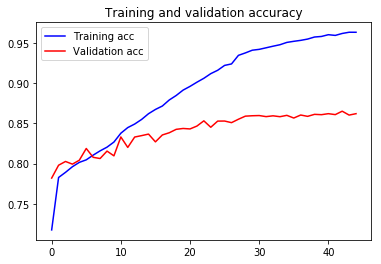

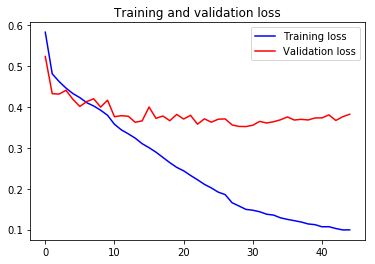

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

from tensorflow.keras.preprocessing.image import load_img
from skimage.io import imread
from skimage import transform

test_df = df_data.iloc[num_train_samples+num_val_samples:num_train_samples+num_val_samples*2]

test_df['image'] = test_df['path'].map(imread)
test_df['image'] = test_df['image'].map(lambda x: transform.resize(x, (224, 224)))

K_test = np.stack(test_df["image"].values)
K_test = (K_test - K_test.mean()) / K_test.std()
predictions = my_new_model.predict(K_test)

print (prediction.shape)
test_df['label'] = predictions

test_df['final_label'] = test_df['label'].map(lambda x: 1 if x>0.5 else 0)

test_df.head(20)


test_error = test_df[test_df[current_style] != test_df['final_label']]

print (test_df.shape, test_error.shape)

In [13]:
# Show the errors
count_max = 8

for i in test_error.index: 
    #original = load_img('{}/{}'.format(test_error.path,fnames[errors[i]]))
    print (test_error.loc[i, 'id'])

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
    test_error.loc[i, current_style],
    test_error.loc[i,'final_label'],
    test_error.loc[i,'label'])
        
    original = load_img(test_error.loc[i, 'path'])
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if count_max == 0:
        break
    else:
        count_max = count_max - 1

NameError: name 'test_error' is not defined

# Show the errors
count_max = 8

for i in test_error.index: 
    #original = load_img('{}/{}'.format(test_error.path,fnames[errors[i]]))
    print (test_error.loc[i, 'id'])

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
    test_error.loc[i, current_style],
    test_error.loc[i,'final_label'],
    test_error.loc[i,'label'])
        
    original = load_img(test_error.loc[i, 'path'])
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if count_max == 0:
        break
    else:
        count_max = count_max - 1

# Show the errors
count_max = 8

for i in test_error.index: 
    #original = load_img('{}/{}'.format(test_error.path,fnames[errors[i]]))
    print (test_error.loc[i, 'id'])

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
    test_error.loc[i, current_style],
    test_error.loc[i,'final_label'],
    test_error.loc[i,'label'])
        
    original = load_img(test_error.loc[i, 'path'])
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    
    if count_max == 0:
        break
    else:
        count_max = count_max - 1

In [14]:
test_gen.reset()
pred=my_new_model.predict_generator(test_gen,steps=test_steps,verbose=1)


1000/1000 [==============================] - 12s 12ms/step


In [15]:
pred_bool = (pred >0.5)

print (pred_bool.shape)

(1000, 12)


In [16]:
predictions = pred_bool.astype(int)
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=cols)
results["Filenames"]=test_gen.filenames
ordered_cols=["Filenames"]+cols
results=results[ordered_cols]#To get the same column order
results.to_csv("results.csv",index=False)
results.head()

,Filenames,zhongguofeng,zhongshi,zhuti,weimei,fugu,daqi,xiaoqingxin,menghuan,senxi,jianjie,xishi,hanshi
0,100001307_4.jpeg,1,1,1,0,0,0,0,0,0,0,0,0
1,123458185_8.jpeg,0,0,0,0,0,0,0,0,0,0,1,0
2,123457879_3.jpeg,0,0,0,1,0,0,1,0,0,0,0,0
3,123458155_4.jpeg,0,0,0,1,0,1,0,0,0,0,0,0
4,123457762_18.jpeg,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
print(os.listdir("./"))

['model_multi_label.h5', 'results.csv', '__output__.json', '__notebook__.ipynb']
